### Import Required Packages

In [1]:
import sys
sys.path.append('../.')

import torch
import torch.distributed
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

from downstream.precip.precip_dataloader import TrainingDataModule, PrecipDataset, create_dataloader
from downstream.precip.lightning_presetup import GAIAPrecip

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-04-24 12:51:36,085] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpvzykj5sk/test.c -o /tmp/tmpvzykj5sk/test.o
INFO:root:x86_64-linux-gnu-gcc /tmp/tmpvzykj5sk/test.o -laio -o /tmp/tmpvzykj5sk/a.out
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpzxqor2qm/test.c -o /tmp/tmpzxqor2qm/test.o
INFO:root:x86_64-linux-gnu-gcc /tmp/tmpzxqor2qm/test.o -L/usr/local/cuda -L/usr/local/cuda/lib64 -lcufile -o /tmp/tmpzxqor2qm/a.out
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpizocejf0/test.c -o /tmp/tmpizo

# Load model from checkpoint

In [7]:
# Define path to config file
config_path = "../configs/precip_config.yaml"

# Create model using config file
model = GAIAPrecip(
    config_path=config_path
)

model.configure_model()

checkpoint_dir = '../checkpoints/gaia-precip-v1.pt'
state_dict = torch.load(checkpoint_dir)
model.load_state_dict(state_dict)

INFO:downstream.precip.lightning_wrapper:Mask Ratio: 0.1


<All keys matched successfully>

### Run Inference

In [8]:
def run_inference(model, num_samples, device='cuda', dtype=torch.float32, mask_ratio=0.5, 
                  data_path="../data/IR", **dataloader_kwargs):
    model.eval()
    model.to(device)
    model.eval()  

    loader = create_dataloader(
        data_path=data_path,
        **dataloader_kwargs
    )
    samples_collected = 0

    for batch in tqdm(loader, desc="Running Inference", unit="sample"):
        # Extract inputs and metadata
        x = batch.get("x")  # Input images
        x_mask = batch.get("x_mask")  # GOES masks
        precip_missing_data_mask = batch.get("y_mask")  # Precip masks
        precip_target = batch.get("y")  # Target images
        temporal_pos = batch.get("temporal_pos")  # Temporal position metadata

        x = x.float().to(device)
        x_mask = x_mask.to(device)
        precip_target = precip_target.to(device)
        precip_missing_data_mask = precip_missing_data_mask.to(device)
        _temporal_pos = [temporal_component.to(device) for temporal_component in temporal_pos]
        temporal_pos = None

        with torch.no_grad():
            mse_loss, pred,mask = model(x, x_mask, precip_target, precip_missing_data_mask, temporal_pos, mask_ratio)

        unpatched = pred  # Shape: [batch, channels, temporal, height, width\
        
        # Convert tensors back to CPU for saving
        imgs = x
        imgs = imgs.float().cpu()
        precip_target = precip_target.float().cpu()
        unpatched = unpatched.float().cpu()
        mask = mask.detach()
        mask = mask.float().cpu()

        s, p, q = model.model.encoder.patch_embed.patch_size
        mask = model.model.encoder.unpatchify(mask.unsqueeze(-1).repeat(1, 1, s * p * q))

        for i in range(min(imgs.size(0), num_samples - samples_collected)):
                plot_reconstructions(
                    input=imgs[i,0,0,:,:],
                    masked_input = imgs[i,0,0,:,:] * (1 - mask[i,0,0,:,:]),
                    ground_truth=precip_target[i,0,0,:,:],
                    reconstruction=unpatched[i,0,0,:,:]
                )
                samples_collected += 1
                if samples_collected >= num_samples:
                    return
                        
def plot_reconstructions(input, masked_input, ground_truth, reconstruction):
    """
    Show ground truth, masked input, and reconstruction.
    """
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    titles = ["Input", "Masked Input", "Ground Truth", "Reconstruction"]
    images = [input, masked_input, ground_truth, reconstruction]

    for ax, img, title in zip(axes, images, titles):
        if title == "Input":
            ax.imshow(img, cmap='jet', vmin=0, vmax=1)
            ax.set_title(title)
            ax.axis("off")
        if title == "Masked Input":
            ax.imshow(img, cmap='jet', vmin=0, vmax=1)
            ax.set_title(title)
            ax.axis("off")
        if title == "Ground Truth":
            img_log = np.log1p(img)  
            ax.imshow(img_log, cmap='jet', vmin=0, vmax=1)
            ax.set_title(title)
            ax.axis("off")
        if title == "Reconstruction":
            img_log = np.log1p(img)
            ax.imshow(img_log, cmap='jet', vmin=0, vmax=1)
            ax.set_title(title)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Running Inference:   0%|                                                                         | 0/4 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
INFO:downstream.precip.lightning_wrapper:forward pass start
INFO:downstream.precip.lightning_wrapper:finished forward
INFO:downstream.precip.models:Mask ratio: 0
INFO:downstream.precip.models:Input imgs shape: torch.Size([2, 1, 1, 480, 1440])
INFO:downstream.precip.models:Input img_masks shape: torch.Size([2, 1, 1, 480, 1440])
INFO:downstream.precip.models:Input precip_target shape: torch.Size([2, 1, 1, 480, 1440])
INFO:downstream.precip.models:Input precip_missing_data_mask shape: torch.Size([2, 1, 1, 480, 1440])
INFO:downstream.precip.models:Latent shape: t

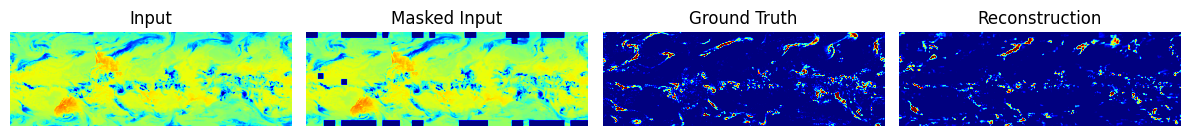

Running Inference:   0%|                                                                         | 0/4 [00:31<?, ?sample/s]


In [9]:
# Example call using your custom dataloader
run_inference(
    model=model,
    data_path="../data",
    num_samples=1,
    device='cuda',
    mask_ratio=0,
    max_files=20,
)